# Distortion Correction Maps

<script src="https://cdn.jsdelivr.net/gh/plexoos/pub-docs@0be43f5/assets/ipynb.js"></script>
 
<a id="toggle_all_input" href="#" data-show-input="false" onclick="toggleAllInput(this); return false;">Show/Hide input</a>

##  $E \times B$ distortion due to the shape of the magnetic field

The following describes how the distortion correction due to the shape of the magnetic field
is implemented in the tpc-rs library. Specifically, we refer here to the Distorter class of
tpc-rs in v0.3.0. For details see the actuall code at
https://github.com/BNLNPPS/tpc-rs/blob/v0.3.0/include/tpcrs/detail/distorter.h

This implementation assumes a homogeneous electric field within the TPC.

The Simpson's integration rule is used to calculate the corrections via the integrals over $z$

\begin{align}
\delta_x &= c_2 \int \frac{B_x}{B_z} - c_1 \int \frac{B_y}{B_z} \\
\delta_y &= c_1 \int \frac{B_y}{B_z} + c_2 \int \frac{B_x}{B_z}
\end{align}

The number of steps (at least 5) is chosen dynamicaly based on the step size that is required to be at most 1cm.

The calculation depends on the following constants:

\begin{align}
c_0 &= \frac{1}{1. +  T_2^2 \omega^2 \tau^2} \\
c_1 &= \frac{T_1 \omega\tau }{ 1. + T_1^2 \omega^2 \tau^2 } \\
c_2 &= \frac{T_2^2 \omega^2 \tau^2 }{ 1 + T_2^2 \omega^2 \tau^2 }
\end{align}

\begin{align}
\omega\tau =  B_z \frac{-10.0 v_d}{E_z} 
\end{align}


The tensor components have the following values: $T_1 = 1.1$, $T_2 = 1.1$.
With the nominal values for the magnetic $B_z = 14$ kG and electric $E_z = 400$ V/cm fields the above equations yield:

\begin{align}
c_0 = 0.0954 \\
c_1 = -0.2937 \\
c_2 = 0.9046 \\
\omega_\tau = -2.8
\end{align}

The magnetic field map is described in this [notebook](https://nbviewer.jupyter.org/github/plexoos/pub-docs/blob/master/npps-tpc-rs/mag_field.ipynb)

In this implementation $\delta_z$ corrections are expected to be negligible.

The config file is created from an existing file used for STAR. Here are the patch showing the differences in the parameters used in the calculation of distortions.

```diff
$diff -u data-64/starY12_pp500.yaml data-64/sphenix_test.yaml
@@ -8018,8 +8018,8 @@
     max: 0
     a: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 Calibrations/tpc/tpcDriftVelocity:
-  laserDriftVelocityEast: 5.5693202
-  laserDriftVelocityWest: 5.56790018
+  laserDriftVelocityEast: 8.0 # cm/us
+  laserDriftVelocityWest: 8.0 # cm/us
   cathodeDriftVelocityEast: 0
   cathodeDriftVelocityWest: 0
 Calibrations/tpc/TpcdXCorrectionB:
@@ -12288,11 +12288,11 @@
 Calibrations/tpc/ResponseSimulator:
   min_signal: 0.0001
   electron_cutoff_energy: 0.001
-  nominal_magnetic_field: 4.979799 # kGauss
-  nominal_electric_field: 133.169 # V/cm
-  readout_plane_z: 208.707 # Nominal distance to readout plane, cm
-  mag_field_file: bfield_full_positive_2D.dat
-  mag_field_scale: 0.001 # Scale values read from the file (e.g. if not in kGauss)
+  nominal_magnetic_field: 14 # kGauss
+  nominal_electric_field: 400  # V/cm
+  readout_plane_z: 100 # Nominal distance to readout plane, cm
+  mag_field_file: bfield_sphenix_test_2D.dat # Values are in Gauss
+  mag_field_scale: -0.00093 # Scale values read from the file (e.g. if not in kGauss)
 Calibrations/tpc/TpcRowQ:
   - type: 0
     idx: 0
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("corr.dat", sep='\s+', names=['r', 'p', 'z', 'corrr', 'corrp', 'corrz'])
#df
df = df.round({'corrz': 4})
#df.nunique()

In [3]:
def plot_corr_slice(ax, df):
    ax = ax.ravel()
    assert len(ax) >= 3, "expected three axes"

    r = df.r.unique()
    p = df.p.unique()/180*np.pi
    z = df.z.unique()
 
    if len(z) == 1:
        xx, yy = np.meshgrid(p, r)
        xlabel = '$\phi$'
        ylabel = 'r, cm'
        title  = f'z = {z[0]}'
    elif len(p) == 1:
        xx, yy = np.meshgrid(z, r)
        xlabel = 'z, cm'
        ylabel = 'r, cm'
        title  = f'p = {p[0]:.3f}'
    elif len(r) == 1:
        xx, yy = np.meshgrid(z, p)
        xlabel = 'z, cm'
        ylabel = '$\phi$, rad'
        title  = f'r = {r[0]}'

    for i, (var, var_title) in enumerate({'corrr': '$\delta_r$', 'corrp': '$\delta_\phi$', 'corrz': '$\delta_z$'}.items()):
        a = ax[i]
        pcm = a.pcolormesh(xx, yy, df[var].values.reshape(xx.shape))
        a.set_xlabel(xlabel)
        a.set_ylabel(ylabel)
        a.set_title(f'{var_title} correction, {title}', pad=20)
        a.grid(True)
        cb = fig.colorbar(pcm, ax=a, pad=0.1)
        cb.ax.set_xlabel('cm')

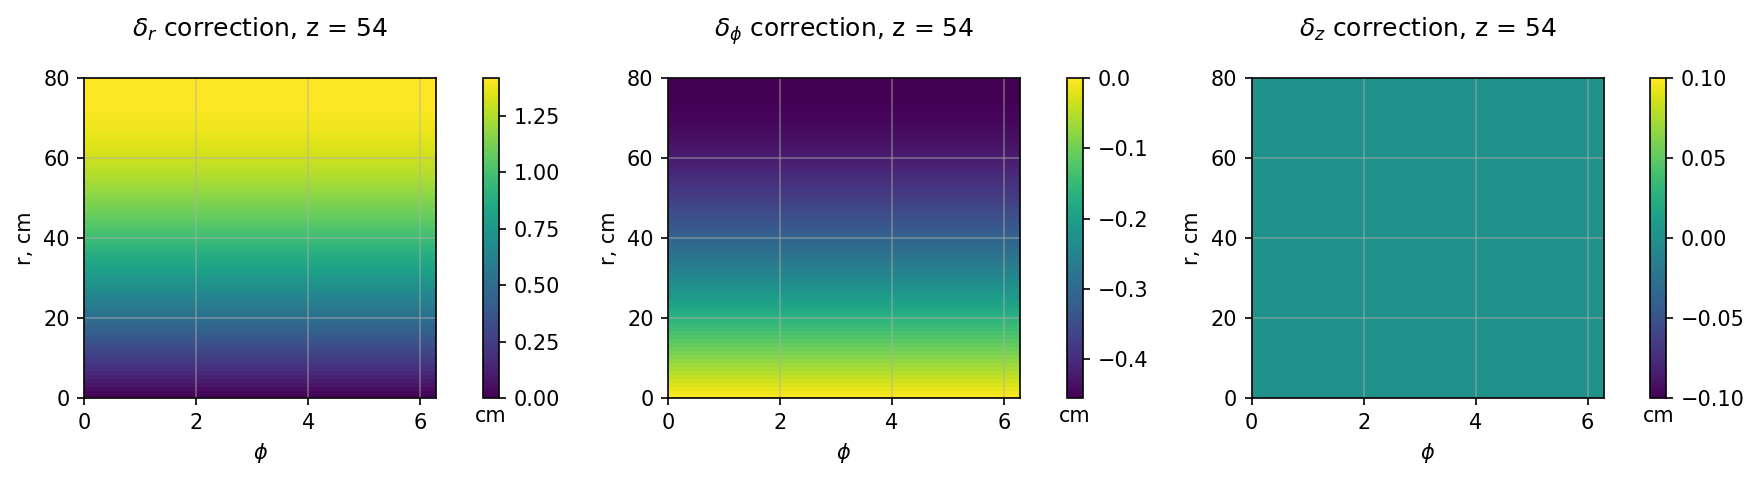

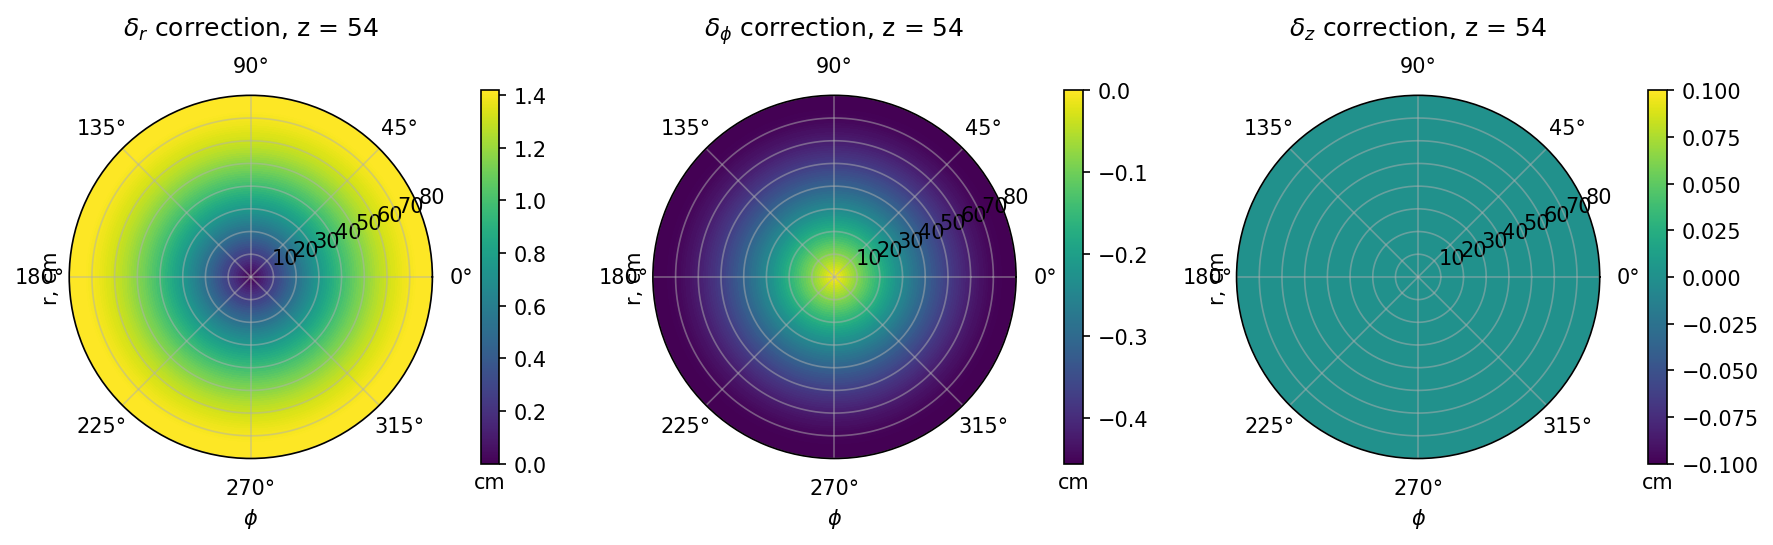

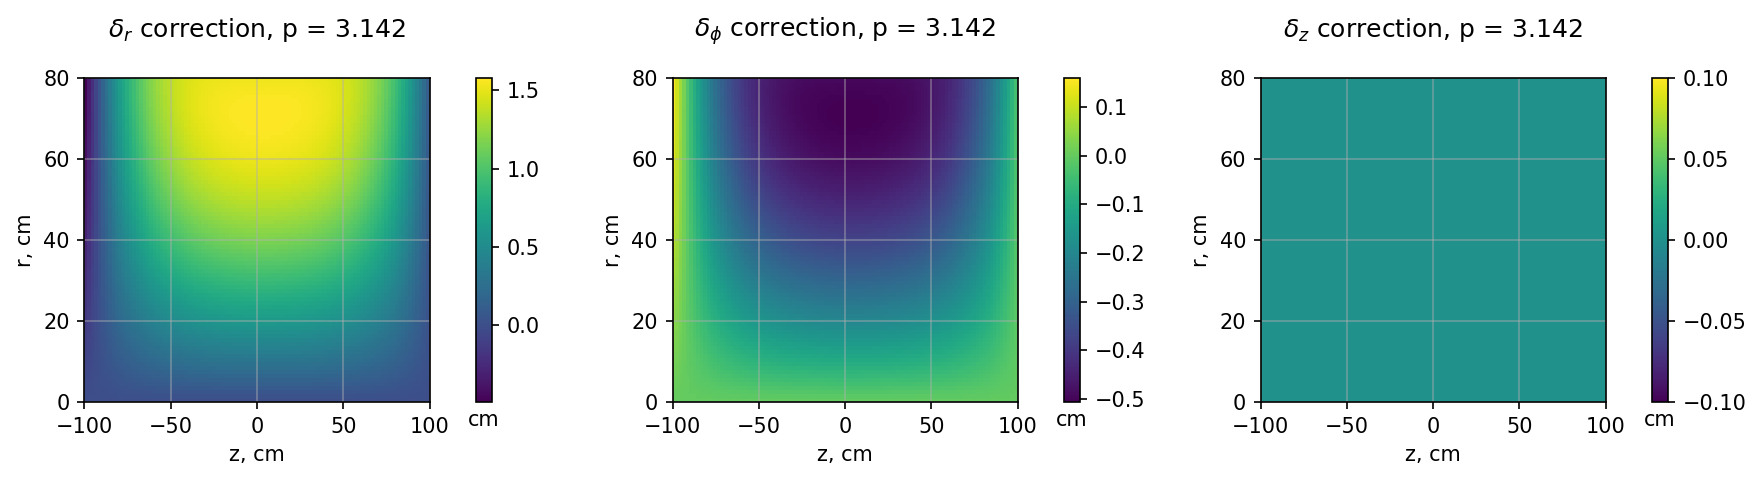

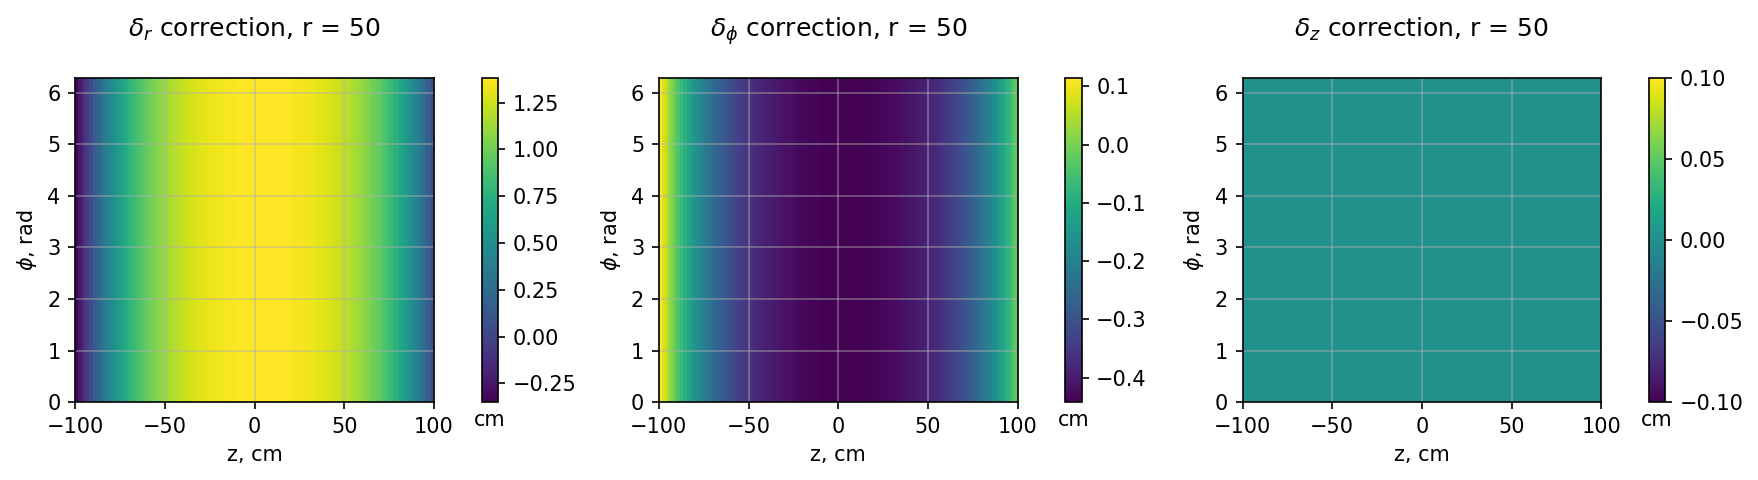

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.3))
df_slice = df.loc[(df.z == 54)]
plot_corr_slice(ax, df_slice)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.3), subplot_kw=dict(projection='polar'))
df_slice = df.loc[(df.z == 54)]
plot_corr_slice(ax, df_slice)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.3))
df_slice = df.loc[(df.p == 180)]
plot_corr_slice(ax, df_slice)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3.3))
df_slice = df.loc[(df.r == 50)]
plot_corr_slice(ax, df_slice)
plt.tight_layout()
plt.show()

In [5]:
def plot_corr(ax, df):
    ax = ax.ravel()
    assert len(ax) >= 3, "expected three axes"

    r = df.r.unique()
    p = df.p.unique()
    z = df.z.unique()
 
    if len(z) == 1 and len(p) == 1:
        xlabel = 'r, cm'
        ylabel = '$\delta$, cm'
        title  = f'p = {p[0]} and z = {z[0]}'

    for i, (var, var_title) in enumerate({'corrr': '$\delta_r$', 'corrp': '$\delta_\phi$', 'corrz': '$\delta_z$'}.items()):
        a = ax[i]
        pcm = a.plot(r, df[var])
        a.set_xlabel(xlabel)
        a.set_ylabel(ylabel)
        a.set_title(f'{var_title} correction @ {title}')
        a.grid(True)

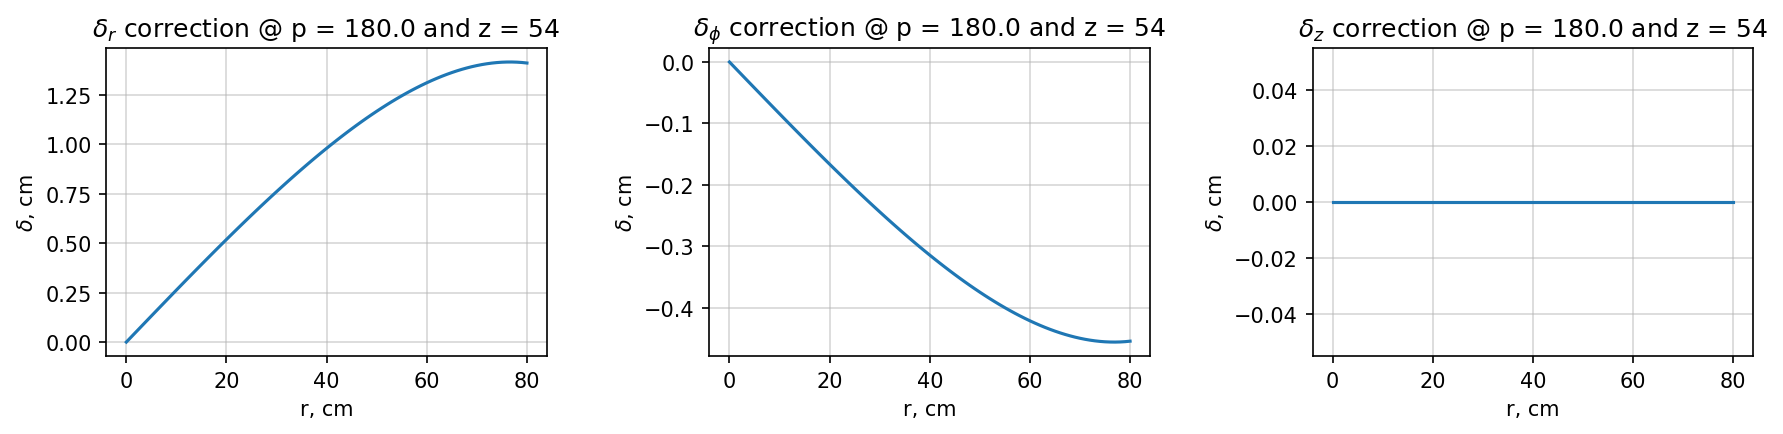

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
df_slice = df.loc[(df.z == 54) & (df.p == 180)]
plot_corr(ax, df_slice)
plt.tight_layout()
plt.show()

The above plots created with tpc-rs can be compared to the corresponding plots produced by Ross

![Distortion maps sPHENIX](graphics/distortion_maps_sphenix.png)